## Setups

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage
import mne
from scipy.signal import welch

import torch
import keras
from sklearn.manifold import TSNE
import json
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from src.EEGModalNet.models.WGAN import WGAN_GP
from tqdm.auto import tqdm


# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_step_losses(step_loss_history):
    plt.figure(figsize=(10, 5))
    plt.plot(step_loss_history.step_losses['d_loss'], label='discriminator')
    plt.plot(step_loss_history.step_losses['g_loss'], label='generator')
    plt.legend()
    plt.show()

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, ch=0, fmax=60, n_fft=512, label='real', show=True):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, :, [ch]].flatten(0, 1).permute(1, 0).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    plt.plot(freq, 10*np.log10(psd.mean(0)), label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def plot_tsne(x, x_gen, ch=0):
    x, x_gen = x[:, :, [ch]], x_gen[:, :, [ch]]
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    tsne = TSNE(n_components=2, verbose=1, perplexity=20)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

def plot_psd4sujects(x, channels):
    """ Plot the power spectral density for different channels for each subjects """
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, n_fft=128, fmax=60)
    for j in range(x.shape[0]):
        plt.figure(figsize=(10, 5))
        for i in range(x.shape[1]):
            plt.plot(freq, 10*np.log10(psd[j, i, :]))
        # stick the channel name to the corresponding line
        for i in range(61):
            plt.text(60, 10*np.log10(psd[j, i, -1]), channels[i], fontsize=8)
        plt.title(f'Subject {j}')
        plt.show()

def plot_psd4subjects_channel(xarray, n_subjects=20, ch_list=['O1'], fmin=1, fmax=64):
    sub_ids = xarray.subject[:n_subjects].to_numpy()
    x = xarray.sel(subject=xarray.subject[:n_subjects]).to_numpy()
    ch_ids = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ids, 440:]
    psd, freq = mne.time_frequency.psd_array_welch(x, sfreq=128, fmin=fmin, fmax=fmax, n_fft=512)
    psd = 10*np.log10(psd.squeeze(1))
    for i in range(psd.shape[0]):
        plt.plot(freq, psd[i])
        # stick the channel name to the corresponding line
        for i in range(len(sub_ids)):
            plt.text(60, psd[i, -1], sub_ids[i], fontsize=8)
        plt.xlabel('Frequency (Hz)')

def plot_raw4subject_channel(xarray, sub, chann_list=['O1'], start=0, filter=True, filter_range=[1, 60]):
    if isinstance(sub, int):
        x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    else:
        x = xarray.sel(subject=sub).to_numpy()
    idx = find_channel_ids(xarray, chann_list)
    x = x[idx, :]
    if filter:
        x = mne.filter.filter_data(x, 128, filter_range[0], filter_range[1], method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unsqueeze(0)
    x = x.unfold(2, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
    plot_overlap(x, start_from=start)

def save_step_losses(step_losses, filename='step_losses.json'):
    with open(filename, 'w') as f:
        json.dump(step_losses, f)

def get_data_gender_wise(xarray, gender, random_draw=False, n_subjects=20, slicer=0):
    chunk = slicer*n_subjects
    inx = 1 if gender == 'M' else 2
    ids = np.where(xarray.gender == inx)[0]
    assert chunk < len(ids), 'There is no more data to draw from'
    ids = np.random.choice(ids, n_subjects, replace=False) if random_draw else ids[chunk:n_subjects+chunk]
    return xarray.sel(subject=xarray.subject[ids]), xarray.subject[ids]

# Custom Callbacks
# callback to log losses at each step
class StepLossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.step_losses = {'g_loss': [], 'd_loss': []}

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.step_losses['g_loss'].append(logs.get('g_loss'))
        self.step_losses['d_loss'].append(logs.get('d_loss'))

## DATA

In [13]:
# 1. DATA
import numpy as np
from pathlib import Path
data_path = 'data/LEMON_data/EEG_Preprocessed/'

channels = ['F1', 'O1', 'C1', 'P1']
processed = False
filtering = True
choose_gender_wise = True
time_dim = 1024
n_subject = 30
data_chunck = 0

if processed:
    data_ec = {}

    # read epochs data with mne
    for i in Path(data_path).glob('sub-01000*_EC.set'):
        sub_id = i.stem
        raw_ec = mne.io.read_raw_eeglab(i, verbose=False)
        if all(item in raw_ec.ch_names for item in channels):
            raw_ec = raw_ec.pick(channels).get_data()
            data_ec[sub_id] = raw_ec
        else:
            print("Not all items in Channels exist in Raw data, will skip this subject")
            continue

    data = {k: torch.tensor(v).unfold(1, time_dim, time_dim).permute(1, 2, 0) for k, v in data_ec.items()}
    del data_ec

    # create sub_ids
    sub_ids = np.array([]).astype(int)
    for i, k in enumerate(data.keys()):
        sub_ids = np.concatenate((sub_ids, np.array([int(i)]*data[k].shape[0], dtype=int)), dtype=int)

    sub_ids = sub_ids[:, np.newaxis]

    # sanity check
    print(np.unique(sub_ids, return_counts=True))

    x = np.zeros([1, time_dim, 1])
    for k in data.keys():
        x = np.concatenate((x, data[k]), axis=0)
    x = x[1:]
    data = {'x': x, 'sub': sub_ids}

else:
    # data
    data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
    xarray = xr.open_dataarray(data_path, engine='h5netcdf')

    if choose_gender_wise:
        xm, male_ids = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        xf, female_ids = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=n_subject//2, slicer=data_chunck)
        x = xr.concat([xm, xf], dim='subject').to_numpy()
        sub_ids = xarray.subject[:n_subject].to_numpy()
    
    else:
        sub_ids = xarray.subject[:n_subject].to_numpy()
        x = xarray.sel(subject=xarray.subject[:n_subject]).to_numpy()

    ch_list = channels
    ch_ind = find_channel_ids(xarray, ch_list)
    x = x[:, ch_ind, 440:]
    if filtering:
        x = mne.filter.filter_data(x, 128, 1, None, method='fir', verbose=False)  # filter data
    x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
    sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
    pos = xarray.ch_positions[ch_ind][None].repeat(x.shape[0], 0)
    data = {'x': x, 'sub': sub, 'pos': pos}

### Data Quality Check

Effective window size : 4.000 (s)


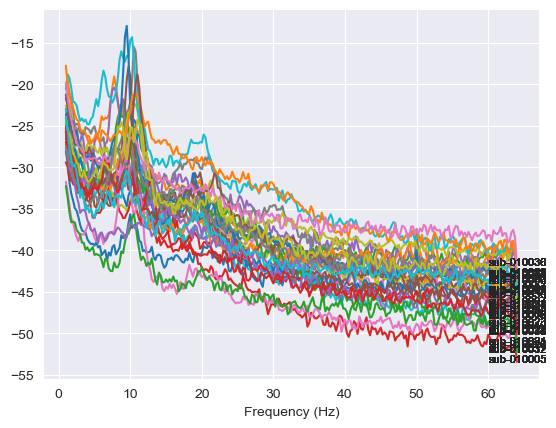

In [4]:
# make sure the PSD of the data across all the recordings is in the right shape
ch_num = 0
plot_psd4subjects_channel(xarray, n_subjects=30, ch_list=channels[ch_num], fmin=1, fmax=64)

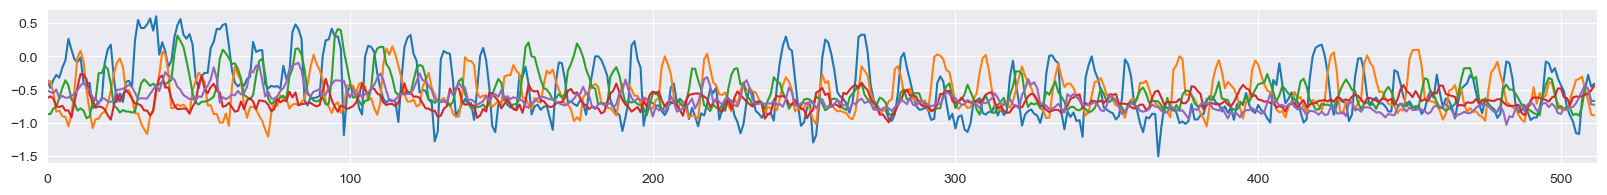

In [5]:
# inspect the data with deviant channel in time domain
sub_id = 'sub-010024'
plot_raw4subject_channel(xarray, sub=sub_id, chann_list=channels[0], start=0, filter=False, filter_range=[1, 60])

In [6]:
# check if this specific channel is excluded in LEMON preprocessed dataset
excluded_chs = pd.read_csv('data/LEMON_data/excluded_channels_ec.csv', index_col=0)
excluded_chs.loc[male_ids.values]

,bad_channels
sub-010002,"['T7', 'TP7']"
sub-010003,['T7']
sub-010004,NaN
sub-010006,['T7']
sub-010007,"['FC1', 'T7', 'T8', 'O1']"
sub-010012,NaN
sub-010016,"['T7', 'T8']"
sub-010019,NaN
sub-010021,NaN
sub-010023,NaN


## TRAINING

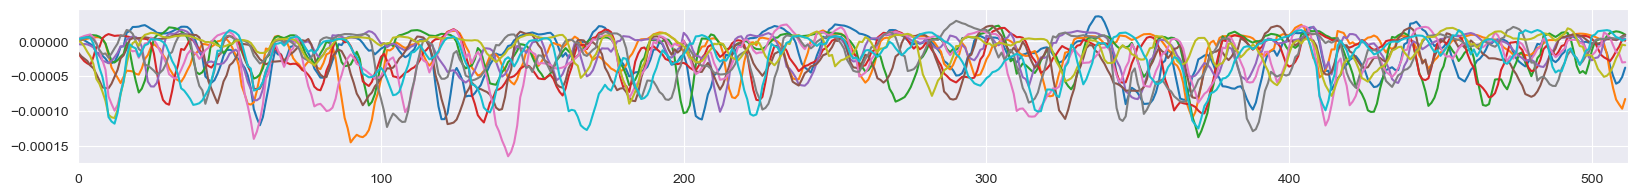

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


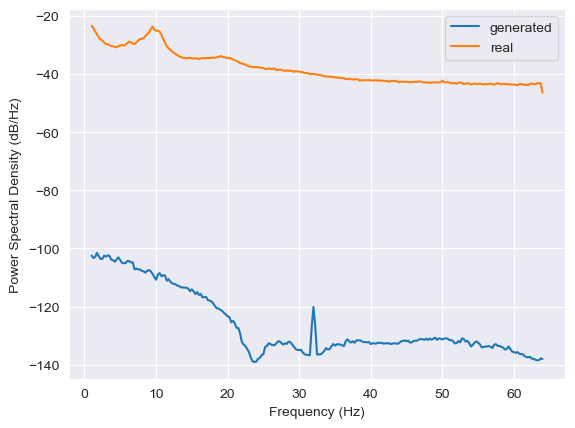

In [15]:
# 2. MODEL and Plot generated data by the model before training
load_model = False
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=True, kerner_initializer='random_normal')
if load_model:
    wgan_gp.load_weights('data/trainings/training_29082024/models/Multich_chF1-O1_sub20_epo140.model.keras')

x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                          pos).cpu().detach()
plot_overlap(x_gen, n_seg=10, start_from=20)
plot_psd(x_gen, fmin=1, ch=1, fmax=200, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=1, fmax=200, n_fft=512, label='real', show=True)
plt.show()

In [16]:
# torch.cuda.empty_cache() # clear GPU memory before training
step_loss_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=1.0)

# early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500)

In [34]:
# training
batch_size = 64
history = wgan_gp.fit(data, epochs=50, batch_size=batch_size, callbacks=[step_loss_history, early_stopping], shuffle=True)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - critic_grad_norm: 2.5901 - d_loss: 0.0553 - g_loss: 4.0527
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - critic_grad_norm: 2.1172 - d_loss: 0.3394 - g_loss: 3.1723
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - critic_grad_norm: 2.2121 - d_loss: -0.6776 - g_loss: 8.8433
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - critic_grad_norm: 3.9357 - d_loss: 0.2880 - g_loss: 1.4556
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 264ms/step - critic_grad_norm: 2.3955 - d_loss: -0.5754 - g_loss: -4.9044
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - critic_grad_norm: 3.0398 - d_loss: 0.3797 - g_loss: 4.7775
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - critic_grad_norm: 2.1527 - d_loss: -0.5673 - g_loss: 9.8393 
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - critic_grad_norm: 2.3502 - d_loss: -0.0043 - g_loss: 3.6475
Epoch 9/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 268ms/step - critic_grad_norm: 3.1746 - d_loss: -

Text(0.5, 1.0, 'Critic Gradient Norm')

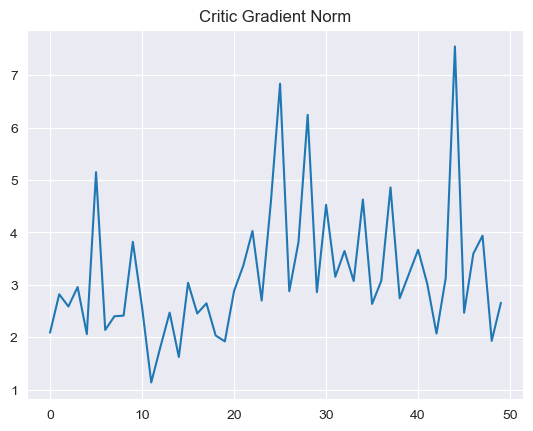

In [35]:
plt.plot(history.history['critic_grad_norm'])
plt.title('Critic Gradient Norm')

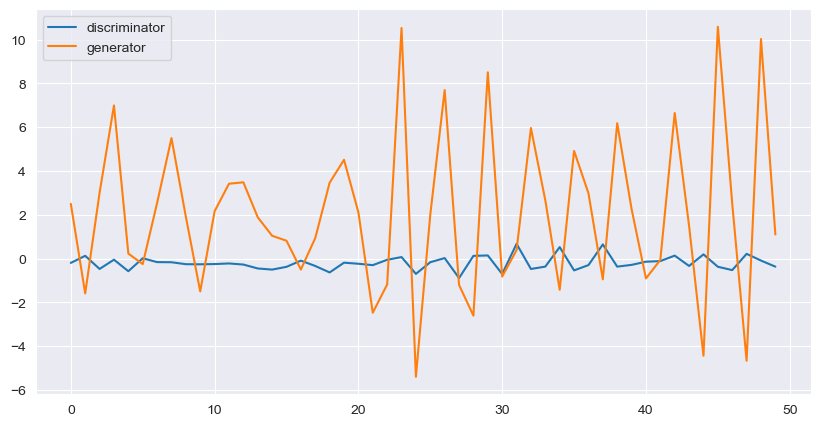

In [36]:
plot_history(history)

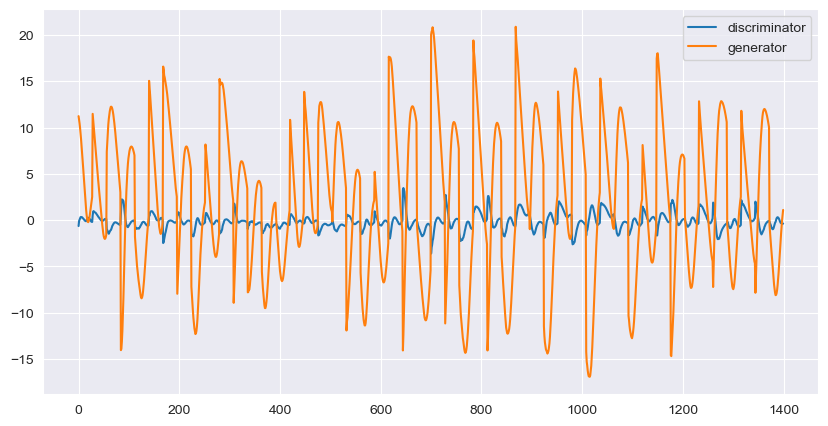

In [37]:
plot_step_losses(step_loss_history)

In [52]:
save_step_losses(step_loss_history.step_losses, filename='data/trainings/training_29082024/step_losses/LeakyMch_step_losses_1.json')
wgan_gp.save('data/trainings/training_29082024/models/Multich-leakyrelu_chF1-O1-C1-P1_sub20_epo100.model.keras')

## Evaluations & Visualisations

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
sigmoid(wgan_gp.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).mean().item()), sigmoid(wgan_gp.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).mean().item())

(2.899053845405224e-07, 5.093045722817542e-07)

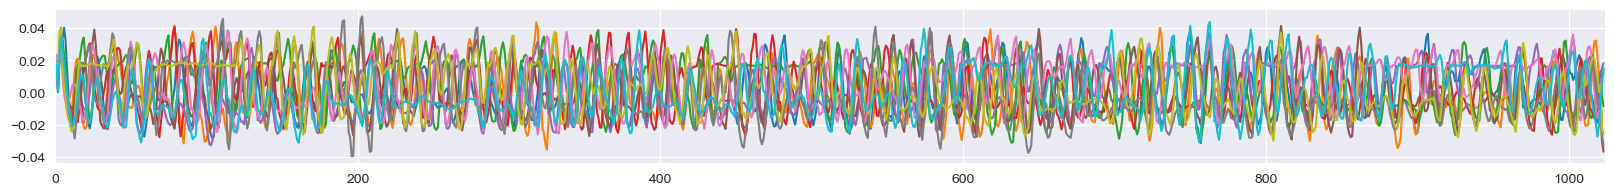

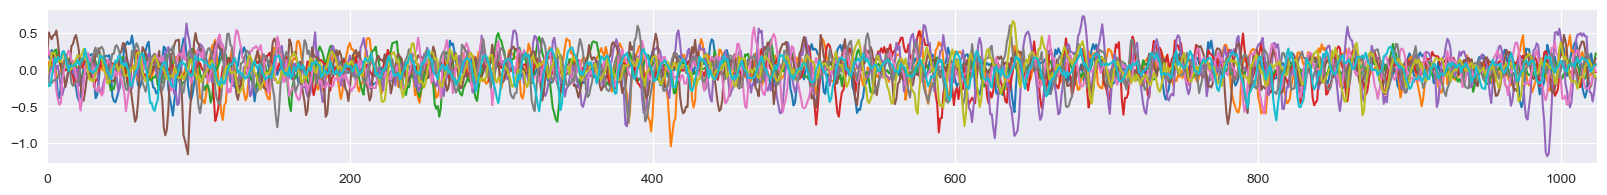

In [42]:
ch = 3
x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()),
                          torch.tensor(sub).to('mps'), pos).cpu().detach()
# x_gen = wgan_gp.generator.sub_layer(x_gen.to('mps'), torch.tensor(sub).to('mps')).cpu().detach()
# filter the generated data and real data
# x_gen = mne.filter.filter_data(x_gen.numpy().astype('float'), 128, 1, 20, method='fir', verbose=False)
# x = mne.filter.filter_data(x.numpy(), 128, 1, 20, method='fir', verbose=False)
plot_overlap(x_gen, n_seg=10, ch=ch, start_from=100, time_dim=1024, show=False)
plot_overlap(x, n_seg=10, ch=ch, start_from=100, time_dim=1024, show=False)
plt.show()

### PSDs

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


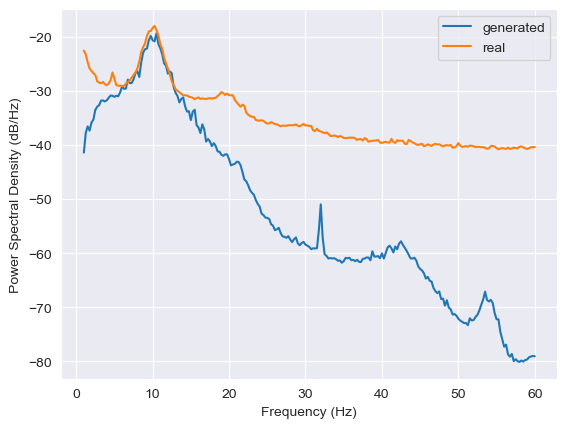

In [43]:
ch = 0
plot_psd(x_gen, fmin=1, ch=ch, fmax=60, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=ch, fmax=60, n_fft=512, label='real', show=True)
plt.show()

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


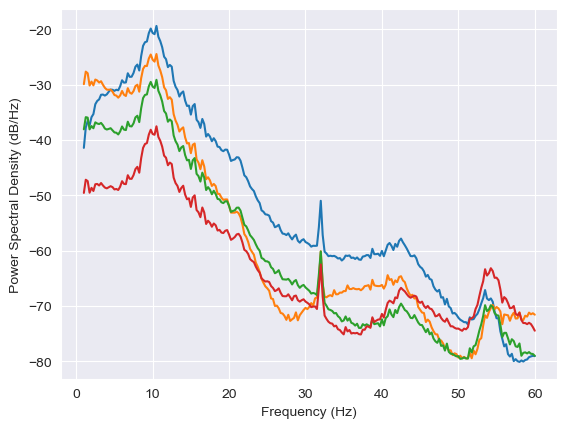

In [45]:
for i in range(4):
    plot_psd(x_gen, fmin=1, ch=i, fmax=60, n_fft=512, label='generated', show=False)

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


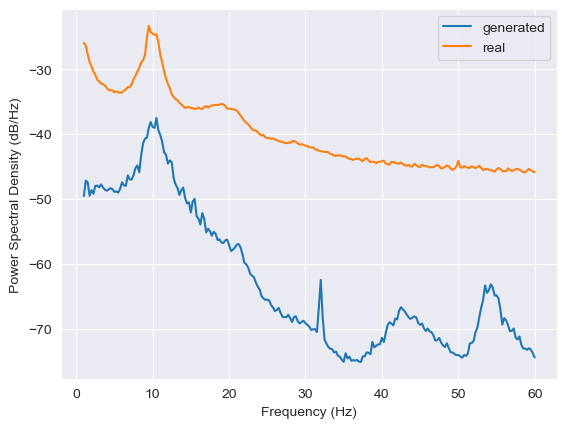

In [44]:
ch = 3
plot_psd(x_gen, fmin=1, ch=ch, fmax=60, n_fft=512, label='generated', show=False)
plot_psd(x, fmin=1, ch=ch, fmax=60, n_fft=512, label='real', show=True)
plt.show()

### tSNE

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3540 samples in 0.001s...
[t-SNE] Computed neighbors for 3540 samples in 0.218s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3540
[t-SNE] Computed conditional probabilities for sample 2000 / 3540
[t-SNE] Computed conditional probabilities for sample 3000 / 3540
[t-SNE] Computed conditional probabilities for sample 3540 / 3540
[t-SNE] Mean sigma: 0.158922
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.210342
[t-SNE] KL divergence after 1000 iterations: 2.725070


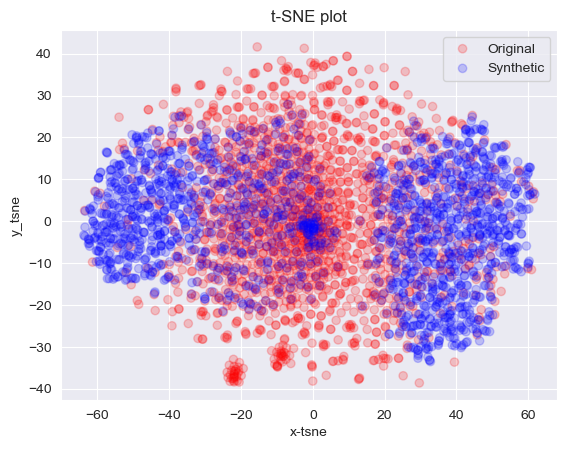

In [36]:
plot_tsne(x, x_gen, ch=0)

## Visualize each layer of Critic's and Generator's output

### Generator

In [47]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()

outputs's shape: (1770, 256)


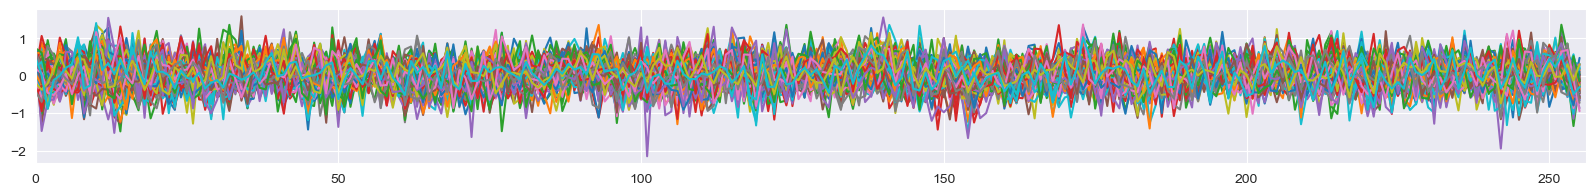

In [23]:
generator = wgan_gp.generator
out = keras.Model(generator.model.layers[0].input, generator.model.layers[2].output)
features = out(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
# features = generator.sub_layer(features, torch.tensor(sub).to('mps')).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Critic

outputs's shape: (1770, 8)


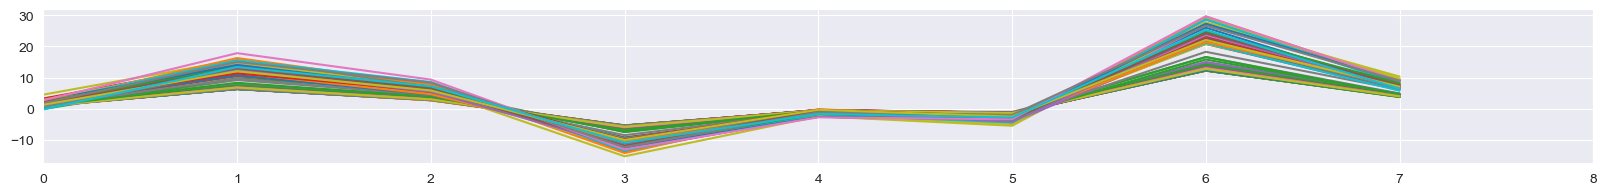

In [48]:
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[-4].output)
features = model(x.float()).cpu().detach().numpy()
print(f"outputs's shape: {features.shape}")
plot_neurons_act(features, across_batch=True, from_to=(0, 100), xlim=features.shape[1])

### Position layer

(0.0, 288.0)

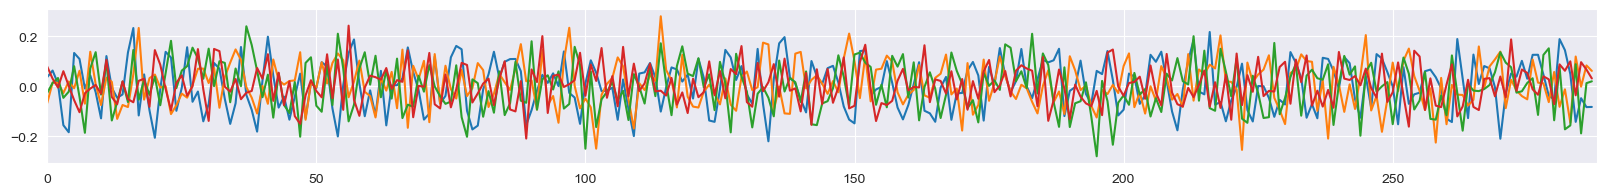

In [51]:
emb2 = wgan_gp.generator.pos_emb.get_weights()[0]
plt.figure(figsize=(20, 2))
for i in range(4):
    plt.plot(emb2[i, :])
plt.xlim(0, 288)

## Feature extraction

In [43]:
### Gender Classification
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold

# helper functions
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    x = x[ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(0, seg_size, seg_size).permute(0, 2, 1)
    return x

def take_ids(sub_ids):
    return np.array([int(i.split('-')[1][-3:]) for i in sub_ids.to_numpy()])

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

def get_data_gender_wise(xarray, gender, random_draw=False, n_subjects=20):
    inx = 1 if gender == 'M' else 2
    ids = np.where(xarray.gender == inx)[0]
    ids = np.random.choice(ids, n_subjects, replace=False) if random_draw else ids[:n_subjects]
    return xarray.sel(subject=xarray.subject[ids]), xarray.subject[ids]

In [44]:
# open data and gender data
# gender classification
ch_list = ['F1', 'O1']
time_dim = 1024
take_rnd = 20
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=True, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=True, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ind, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

In [47]:
# upload the model
# model = WGAN_GP(time_dim=time_dim, feature_dim=1, latent_dim=64, n_subjects=20, use_sublayers=True)
# model.load_weights('tmp/keras_models/wgan_gp_with_sub_layer.model.keras')
critic = wgan_gp.critic
model = keras.Model(inputs=critic.model.layers[0].input, outputs=critic.model.layers[-6].output)
# x_ = critic.sub_layer(x.float().to('mps'), torch.tensor(sub).to('mps'))
features = model(x.float()).cpu().detach().numpy()
features.shape

(2360, 32)

In [48]:
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 48.67% ±10.92%


In [134]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

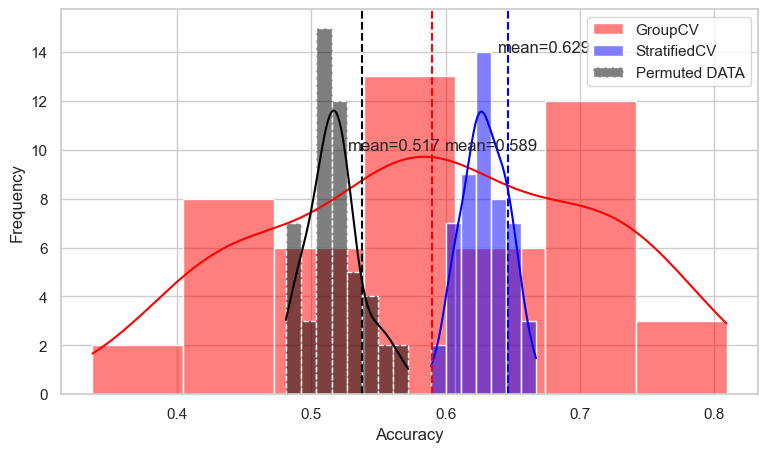

In [135]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### Ensemble networks

In [68]:
# 1. DATA
# open data and gender data
# gender classification
ch_list = ['O1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

# concate features from different networks
wgan = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=30, use_sublayer_generator=True)
wgan.load_weights('data/trainings/training_23082024/model/mostpromising_withsublayerInGenerator_chO1_sub30_epo100_trained_with_different_data.model.keras')

mode1_o1 = wgan.critic
mode1_o1 = keras.Model(inputs=mode1_o1.model.layers[0].input, outputs=mode1_o1.model.layers[-5].output)
features_o1 = mode1_o1(x.float()).cpu().detach().numpy()

In [64]:
ch_list = ['F1']
time_dim = 1024
take_rnd = 40
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
xf, _ = get_data_gender_wise(xarray, 'F', random_draw=False, n_subjects=take_rnd)
xm, _ = get_data_gender_wise(xarray, 'M', random_draw=False, n_subjects=take_rnd)
xf_ = torch.tensor(xf.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
xm_ = torch.tensor(xm.to_numpy()[:, ch_ids, 440:]).unfold(-1, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf_, xm_), axis=0)

# gender labels
labels = np.array([0]*xf_.shape[0] + [1]*xm_.shape[0])

# subject ids for grouped cross validation
xf_ids, xm_ids = take_ids(xf.subject).repeat(xf_.size(0)//take_rnd), take_ids(xm.subject).repeat(xm_.size(0)//take_rnd)
sub_ids = np.concatenate((xf_ids, xm_ids))

wgan_f1 = WGAN_GP(time_dim=1024, feature_dim=1, latent_dim=64, n_subjects=40, use_sublayer_generator=True)
wgan_f1.load_weights('data/trainings/training_25082024/models/withResidualsInCriticV2_chF1_sub40_epo1381.model.keras')
model_f1 = wgan_f1.critic
model_f1 = keras.Model(inputs=model_f1.model.layers[0].input, outputs=model_f1.model.layers[-5].output)
features_f1 = model_f1(x.float()).cpu().detach().numpy()

In [58]:
# concate features
features = np.concatenate((features_o1, features_f1), axis=1)

In [69]:
features = features_o1
cv_g = GroupShuffleSplit(n_splits=50, test_size=0.2)
cv_s = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)
# scores_s = cross_val_score(pipe, features, labels, cv=cv_s, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 53.28% ±7.56%


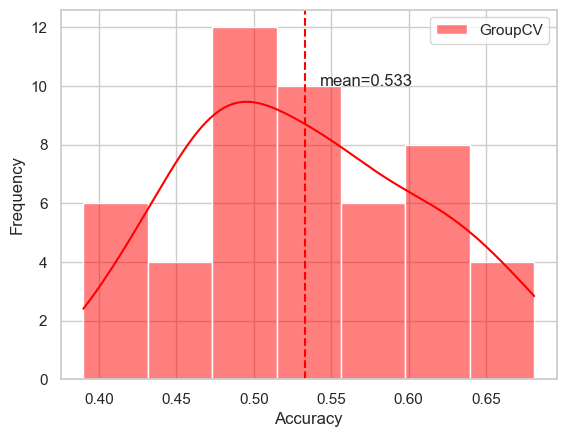

In [70]:
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

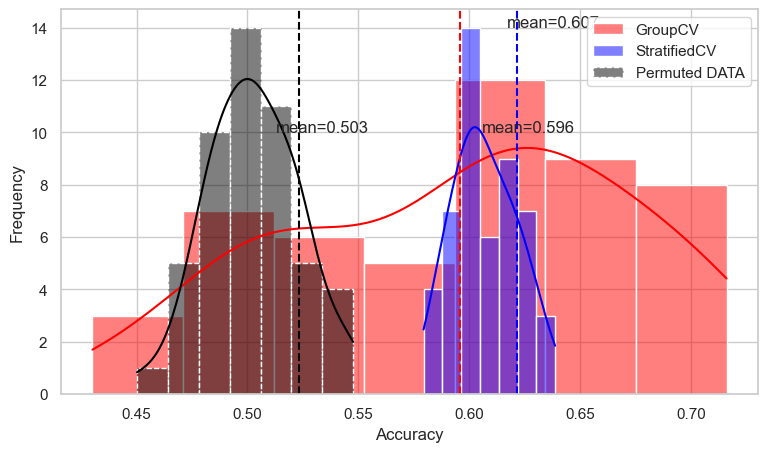

In [63]:
# visualizations
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(9, 5))
sns.histplot(scores_g, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(scores_s, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores_sh, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(scores_g).mean(), color='red', linestyle='--')
plt.axvline(np.array(scores_s).mean() + np.array(scores_s).std(), color='blue', linestyle='--')
plt.axvline(np.array(scores_sh).mean() + np.array(scores_sh).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(scores_g).mean() + 0.01, 10, f'mean={np.array(scores_g).mean():.3f}', fontsize=12)
plt.text(np.array(scores_s).mean() + 0.01, 14, f'mean={np.array(scores_s).mean():.3f}', fontsize=12)
plt.text(np.array(scores_sh).mean() + 0.01, 10, f'mean={np.array(scores_sh).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

In [62]:
# shuffle the labels for permutation test
np.random.shuffle(labels)
scores_sh = cross_val_score(pipe, features, labels, cv=cv_g, groups=sub_ids, n_jobs=-1)

### Notes
using the final output of the critic, results in a highest accuracy!! (could not replicate this result!)
it seems that the conv layers of the critic are responsible for getting similar outputs from different layers.


## DEBUG

In [12]:
from keras import layers

class ResidualBlock(layers.Layer):
    def __init__(self, filters, kernel_size, activation='relu', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv1D(filters, kernel_size, padding='same', activation=activation)
        self.conv2 = layers.Conv1D(filters // 2, kernel_size, padding='same', activation=activation,)
        self.conv3 = layers.Conv1D(filters // 4, kernel_size, padding='same')
        self.activation = layers.Activation(activation)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.add([x, inputs])  # shortcut connection
        x = self.activation(x)
        return x
    

model = keras.Sequential([
    keras.Input(shape=(1024, 4)),
    ResidualBlock(16, 5, activation='relu'),
    layers.Conv1D(1, 5, padding='same', activation='relu', name='conv3'),
    layers.Flatten(name='dis_flatten'),
    layers.Dense(512, name='dis_dense1'),
    layers.Dense(1, name='dis_dense2')
], name='critic')

model.summary()

Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ residual_block_7                │ (None, 1024, 4)        │         1,148 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv1D)                  │ (None, 1024, 1)        │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_flatten (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense1 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dis_dense2 (Dense)              │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,482 (2.01 MB)

 Trainable params: 526,482 (2.01 MB)

 Non-trainable params: 0 (0.00 B)